In [2]:
import pandas as pd
import time
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# Haal het dataframe op
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_pc4 = pd.read_hdf('pc4_verbruiksdata.h5')

In [4]:
# Kies een pc4 en vertaal naar een simpel x,y model (index = datum, verbruik is de y-waarde)
df_pc4 = df_pc4[df_pc4.PC4 == 5501]["VERBRUIK"]
df_pc4.head()

DATUM
2010-01-01    35.638680
2010-01-02    38.445606
2010-01-03    36.335540
2010-01-04    37.050146
2010-01-05    36.730582
Name: VERBRUIK, dtype: float64

In [5]:
# Maak een train en test set. De test set wordt de laatste 1/3 van de complete dataset (dus ook in tijd!)
X = df_pc4.values
size = int(len(X) * 0.66)
train,test = X[0:size], X[size:len(X)]

In [6]:
# Wat zijn de beste p,d en q. Geen idee eigenlijk
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
print (model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2892
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2606.824
Date:                Tue, 06 Apr 2021   AIC                           5225.648
Time:                        16:25:56   BIC                           5261.465
Sample:                             0   HQIC                          5238.556
                               - 2892                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7836      0.017    -46.096      0.000      -0.817      -0.750
ar.L2         -0.4002      0.023    -17.087      0.000      -0.446      -0.354
ar.L3         -0.1730      0.027     -6.296      0.0

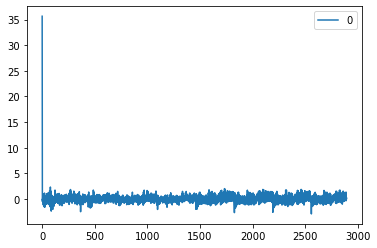

In [7]:
# Plot van de residuals. Ziet er eigenlijk wel goed uit, behalve dan de spike aan het begin. Startprobleem?
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

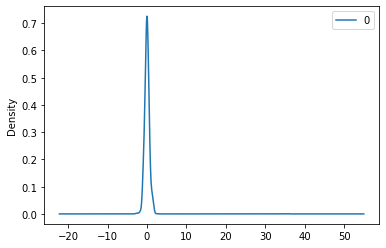

In [8]:
# En de dichtheid van de residuals. Soort van steile gaussische curve rondom 0
residuals.plot(kind='kde')
pyplot.show()

In [9]:
# Samenvatting van de statistiek
print(residuals.describe())

                 0
count  2892.000000
mean      0.008161
std       0.892045
min      -2.919531
25%      -0.368054
50%      -0.013106
75%       0.352586
max      35.638680


In [10]:
# Maak een rolling forecast obv het model
history = [x for x in train]
predictions = list()
overall_start = time.time()

test_size = len(test)
i = 1
for t in range(test_size):
    start = time.time()

    # Bereken de volgende lag
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    # Bereken de executietijd voor deze stap
    end = time.time()
    exec_tijd = format(end - start, '.2f')
    print(f'Stap {format(i, "04d")} van {test_size} stappen. Voorspeld={yhat}, verwacht={obs}. Klaar in {exec_tijd}s')

    i = i + 1

overall_end = time.time()
exec_tijd = overall_end - overall_start
exec_tijd_min = int(exec_tijd / 60)
exec_tijd_sec = int(exec_tijd % 60)
print(f"Totale executietijd is {exec_tijd_min}:{format(exec_tijd_sec, '02d')}")

cht=18.795008299999996. Klaar in 0.46s
Stap 1293 van 1491 stappen. Voorspeld=18.968638166784434, verwacht=19.367211240000007. Klaar in 0.45s
Stap 1294 van 1491 stappen. Voorspeld=19.167721550996625, verwacht=19.185848129999997. Klaar in 0.46s
Stap 1295 van 1491 stappen. Voorspeld=19.198642141777796, verwacht=19.11124248999999. Klaar in 0.46s
Stap 1296 van 1491 stappen. Voorspeld=19.114675547183246, verwacht=19.46776082000001. Klaar in 0.46s
Stap 1297 van 1491 stappen. Voorspeld=19.22615791889585, verwacht=19.416406770000005. Klaar in 0.46s
Stap 1298 van 1491 stappen. Voorspeld=19.31628711700711, verwacht=19.243864000000002. Klaar in 0.46s
Stap 1299 van 1491 stappen. Voorspeld=19.298496823250485, verwacht=19.49085222. Klaar in 0.46s
Stap 1300 van 1491 stappen. Voorspeld=19.35535655863526, verwacht=19.669743190000005. Klaar in 0.46s
Stap 1301 van 1491 stappen. Voorspeld=19.489930318996812, verwacht=19.432745530000002. Klaar in 0.46s
Stap 1302 van 1491 stappen. Voorspeld=19.47688486586653

Test RMSE: 0.752


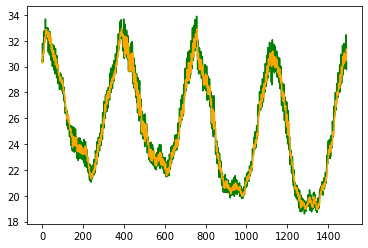

In [11]:
# Evalueer de voorspelling door de RMSE uit te rekenen
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot voorspelling tegen de actuals
pyplot.plot(test, color="green")
pyplot.plot(predictions, color='orange')
pyplot.show()